# Separation



### Loading audio

In [1]:
%%capture
import io, zipfile, soundfile, librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from chimeranet.datasets import DSD100Melody, DSD100Vocal

# load audio
sr = 16000

dsd_path = 'DSD100.zip'
archive_name = 'DSD100/Mixtures/Test/001 - ANiMAL - Clinic A/mixture.wav'
with zipfile.ZipFile(dsd_path, 'r') as zf:
    with zf.open(archive_name, 'r') as f:
        tmp = io.BytesIO(f.read())
        data, _sr = soundfile.read(tmp)
        mixture = librosa.to_mono(librosa.resample(data.T, _sr, sr))
        mixture = mixture[sr*64:sr*70]

# load true melody and vocal
mloader = DSD100Melody(dsd_path, dev=False, test=True)
true_melody = mloader.load(0, sr=sr)
true_melody = true_melody[sr*64:sr*70]

vloader = DSD100Vocal(dsd_path, dev=False, test=True)
true_vocal = vloader.load(0, sr=sr)
true_vocal = true_vocal[sr*64:sr*70]

### Loading model from file and predict

In [2]:
%%capture
import numpy as np
from chimeranet.models import load_model, probe_model_shape
from chimeranet import split_window

model_path = 'dsd100_100.hdf5'

# prepare data
n_fft, hop_length = 512, 128
n_mels = probe_model_shape(model_path)[1]

s = librosa.core.stft(mixture, n_fft, hop_length)
spec, phase = librosa.core.magphase(s)

# make spectrogram of evaluation data
tms, tmp = librosa.core.magphase(librosa.core.stft(true_melody, n_fft, hop_length))
tvs, tvp = librosa.core.magphase(librosa.core.stft(true_vocal, n_fft, hop_length))

mel_basis = librosa.filters.mel(sr, n_fft, n_mels, norm=None)
mel_spec = np.dot(mel_basis, spec)

# split into windows
win_length = probe_model_shape(model_path)[0]
x = split_window(mel_spec, win_length).transpose((0, 2, 1))

# loading model
model = load_model(model_path)

# prediction
y_embedding, y_mask = model.predict(x)

### Reconstruction from `mask` prediction



'predicted vocal'

'true vocal'

'predicted melody'

'true melody'

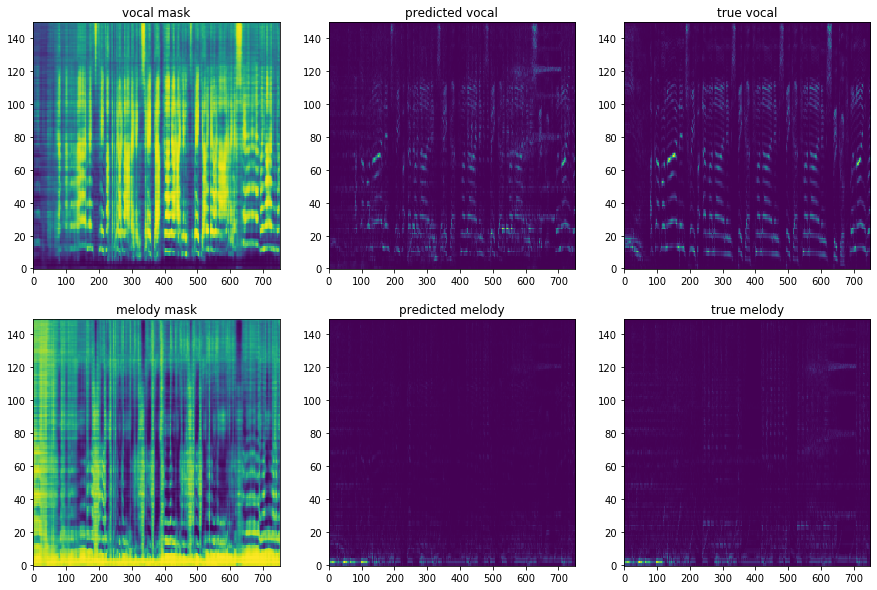

In [3]:
from chimeranet import from_mask, merge_windows_mean

mask_windows = from_mask(y_mask)
masks = merge_windows_mean(mask_windows)[:, :, :mel_spec.shape[1]]

display_objs = []
# Audio
for name, mask, true_spec in zip(('vocal', 'melody'), masks, (tvs*tvp, tms*tmp)):
    pred_spec = np.dot(mel_basis.T, mask * mel_spec)
    for title, out_spec in (
        ('predicted {}'.format(name), pred_spec * phase),
        ('true {}'.format(name), true_spec),
    ):
        out_audio = librosa.core.istft(out_spec, hop_length)
        display_objs.append(title)
        display_objs.append(ipd.Audio(out_audio, rate=sr))
ipd.display(*display_objs)

# Spectrogram
fig = plt.figure(figsize=(15, 10))
for i, (name, mask, true) in enumerate(zip(('vocal', 'melody'), masks, (tvs, tms))):
    for j, (title, image) in enumerate((
        ('{} mask'.format(name), mask),
        ('predicted {}'.format(name), mask * mel_spec),
        ('true {}'.format(name), np.dot(mel_basis, true)),
    ), 1):
        ax = fig.add_subplot(2, 3, 3*i+j)
        ax.title.set_text(title)
        ax.imshow(image, origin='lower', aspect='auto')

### Reconstruction from `embedding` prediction



'channel 1'

'channel 2'

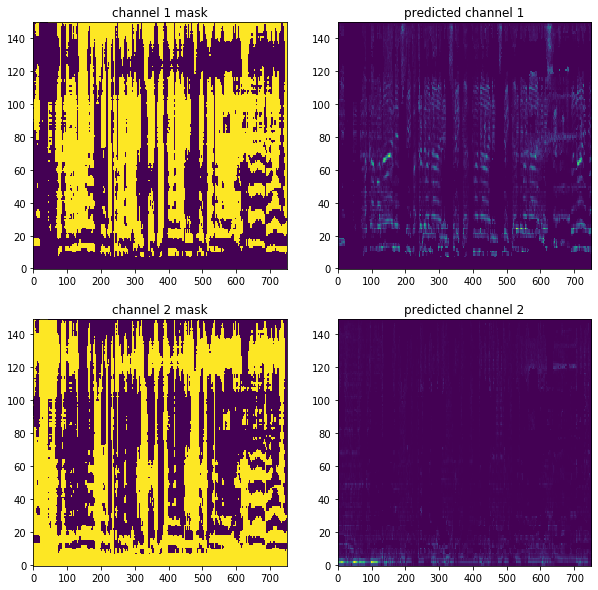

In [4]:
from chimeranet import from_embedding, merge_windows_most_common

n_channels = probe_model_shape(model_path)[2]
mask_windows = from_embedding(y_embedding, n_channels)
masks = merge_windows_most_common(mask_windows)[:, :, :mel_spec.shape[1]]

display_objs = []
# Audio
for i, mask in enumerate(masks, 1):
    pred_spec = np.dot(mel_basis.T, mask * mel_spec)
    pred_audio = librosa.core.istft(pred_spec * phase, hop_length)
    display_objs.append('channel {}'.format(i))
    display_objs.append(ipd.Audio(pred_audio, rate=sr))
ipd.display(*display_objs)

# Spectrogram
fig = plt.figure(figsize=(10, 10))
for i, mask in enumerate(masks, 1):
    name = 'channel {}'.format(i)
    for j, (title, image) in enumerate((
        ('{} mask'.format(name), mask),
        ('predicted {}'.format(name), mask * mel_spec),
    ), 1):
        ax = fig.add_subplot(2, 2, 2*(i-1)+j)
        ax.title.set_text(title)
        ax.imshow(image, origin='lower', aspect='auto')